In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.9 MB/s eta 0:00:00


In [ ]:
!pip install -q datasets sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.6 MB/s eta 0:00:00


In [ ]:
import os
import json
from PIL import Image
from typing import Dict
import random
import cv2
import pandas as pd
import numpy as np
from transformers import VisionEncoderDecoderConfig
from transformers import DonutProcessor, VisionEncoderDecoderModel, BartConfig

**Mounted Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/miniProject/benetech-making-graphs-accessible.zip -d dataset

**Annotation**

In [ ]:
def get_annotations():
    """returns for each graph Its category based on the annotation files"""
    annotations_path = "/content/dataset/train/annotations"
    annotations = {}
    for annotation_path in os.listdir(annotations_path):
        with open(f"{annotations_path}/{annotation_path}") as annotation_f:
            val_type = json.load(annotation_f)["chart-type"] 
            if val_type == 'horizontal_bar':
                continue
            annotations[annotation_path[:-4]+'jpg'] = val_type
    return annotations

In [ ]:
annotations = get_annotations()
classes = set(annotations.values())

**Move data follow class**

In [ ]:
os.mkdir('/content/imagefolder')
os.mkdir('/content/imagefolder/train')
for k in classes : 
    os.mkdir(f'/content/imagefolder/train/{k}')

In [ ]:
import shutil
dirname = '/content/dataset/train/images'
for filename in os.listdir(dirname):
    try:
        src = os.path.join(dirname, filename)
        classe = annotations[filename]
        dst = f'/content/imagefolder/train/{classe}/{filename}'
        shutil.copy(src, dst)
    except:
        continue

**Get data**

In [ ]:
from datasets import load_dataset


dataset = load_dataset("imagefolder", data_dir="/content/imagefolder")

Resolving data files:   0%|          | 0/60505 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-fcc90826cacd8cd2/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x313 at 0x7F0CB085E7D0>,
 'label': 0}

**Adapt Input Donut**

In [ ]:
id2label = {id: label for id, label in enumerate(dataset['train'].features['label'].names)}
print(id2label)

{0: 'dot', 1: 'line', 2: 'scatter', 3: 'vertical_bar'}


In [ ]:
template = '{"gt_parse": {"class" : '
def update_examples(examples):
    ground_truths = []
    for label in examples['label']:
        ground_truths.append(template + '"' + id2label[label] + '"' + "}}")
    examples['ground_truth'] = ground_truths

    return examples

dataset = dataset.map(update_examples, batched=True)

Map:   0%|          | 0/60505 [00:00<?, ? examples/s]

In [ ]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x313 at 0x7F0CB060CF10>,
 'label': 0,
 'ground_truth': '{"gt_parse": {"class" : "dot"}}'}

**Model parameter**

In [ ]:
max_length = 8
image_size = [512,313]
config = VisionEncoderDecoderConfig.from_pretrained("nielsr/donut-base")
config.encoder.image_size = image_size # (height, width)
config.decoder.max_length = max_length

In [ ]:
processor = DonutProcessor.from_pretrained("nielsr/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("nielsr/donut-base", config=config)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
processor.feature_extractor.size = image_size[::-1] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

/usr/local/lib/python3.10/dist-packages/transformers/models/donut/processing_donut.py:186: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


**Prepare dataset training**

In [ ]:
len(processor.tokenizer)

57525

In [ ]:
from typing import List

def add_tokens(list_of_tokens: List[str]):
    """
    Add tokens to tokenizer and resize the token embeddings
    """
    newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
    if newly_added_num > 0:
        model.decoder.resize_token_embeddings(len(processor.tokenizer))

In [ ]:
additional_tokens = ["<dot/>", "<line/>", "<scatter/>", "<vertical_bar/>"]
add_tokens(additional_tokens)

In [ ]:
processor.tokenizer.convert_tokens_to_ids(["<vertical_bar/>"])

[57528]

Next, we create a regular PyTorch Dataset. The class below returns (pixel_values, labels) pairs for each item of the dataset.

It's all we need for training the model!

In [ ]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

class DonutDataset(Dataset):
    """
    DonutDataset which is saved in huggingface datasets format. (see details in https://huggingface.co/docs/datasets)
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into input_tensor(vectorized image) and input_ids(tokenized string).
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = dataset
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in additional_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
    
    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # pixel values (we remove the batch dimension)
        pixel_values = processor(sample["image"].convert("RGB"), random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # labels, which are the input ids of the target sequence
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        
        encoding = dict(pixel_values=pixel_values,
                        labels=labels)
        
        return encoding

In [ ]:
train_set, val_set,test_set = torch.utils.data.random_split(dataset['train'],[0.8,0.1,0.1])
train_dataset = DonutDataset(train_set, max_length=max_length,
                             split="train", task_start_token="<s_rvlcdip>", prompt_end_token="<s_rvlcdip>",
                             sort_json_key=False, 
                             )

val_dataset = DonutDataset(val_set, max_length=max_length,
                             split="val", task_start_token="<s_rvlcdip>", prompt_end_token="<s_rvlcdip>",
                             sort_json_key=False, 
                             )

test_dataset = DonutDataset(test_set, max_length=max_length,
                             split="test", task_start_token="<s_rvlcdip>", prompt_end_token="<s_rvlcdip>",
                             sort_json_key=False, 
                             )

**Create dataloader**

In [ ]:
from torch.utils.data import DataLoader

# I'm using a small batch size to make sure it fits in the memory Colab provides
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))
print(batch.keys())

dict_keys(['pixel_values', 'labels'])


In [ ]:
for id in batch['labels'][0].tolist():
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_class>
<vertical_bar/>
</s_class>
</s>
-100
-100
-100
-100


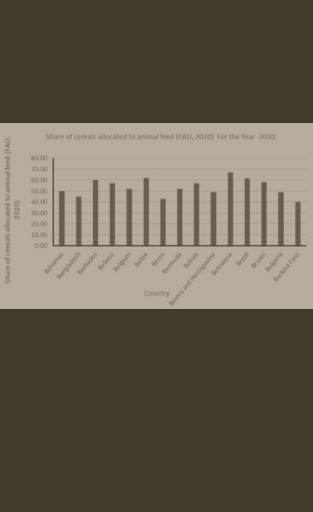

In [ ]:
batch = train_dataset[110]
from PIL import Image
import numpy as np

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# unnormalize
reconstructed_image = (batch['pixel_values'][0] * torch.tensor(std)[:, None, None]) + torch.tensor(mean)[:, None, None]
# unrescale
reconstructed_image = reconstructed_image * 255
# convert to numpy of shape HWC
reconstructed_image = torch.moveaxis(reconstructed_image, 0, -1)
image = Image.fromarray(reconstructed_image.numpy().astype(np.uint8))
image

**Training**

In [ ]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s_rvlcdip>'])[0]

In [ ]:
# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s_rvlcdip>


**Let's train**

In [ ]:
import torch
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)

for epoch in range(10):
    print("Epoch:", epoch+1)
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]

        outputs = model(pixel_values=pixel_values,
                        labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0:
            print("Loss:", loss.item())

Epoch: 1


  0%|          | 0/12102 [00:00<?, ?it/s]

Loss: 16.662752151489258
Loss: 0.32810449600219727
Loss: 0.351863294839859
Loss: 0.1603628396987915
Loss: 0.31248828768730164
Loss: 0.18508419394493103
Loss: 0.33573171496391296
Loss: 0.00550053222104907
Loss: 0.015636881813406944
Loss: 0.40975937247276306
Loss: 0.009026151150465012
Loss: 0.006262660026550293
Loss: 0.014135416597127914
Loss: 0.00046234994078986347
Loss: 0.0016078933840617537
Loss: 0.007032433059066534
Loss: 0.000608116271905601
Loss: 0.00042849520104937255
Loss: 0.0012315690983086824
Loss: 0.0008087115129455924
Loss: 0.2544626295566559
Loss: 0.0013406961224973202
Loss: 0.10493579506874084
Loss: 0.001304979552514851
Loss: 0.003294331720098853
Loss: 0.00045619357842952013
Loss: 0.00629915576428175
Loss: 0.030938711017370224
Loss: 0.00150978600140661
Loss: 0.0505978949368
Loss: 0.4132842421531677
Loss: 0.012465053237974644
Loss: 0.00013975253386888653
Loss: 0.0010895173763856292
Loss: 0.0006760773248970509
Loss: 0.0006430225330404937
Loss: 0.00019351263472344726
Loss: 0.0

  0%|          | 0/12102 [00:00<?, ?it/s]

Loss: 2.008532283070963e-05
Loss: 0.1652071475982666
Loss: 1.641163726162631e-05
Loss: 9.909244909067638e-07
Loss: 2.0712539026135346e-06
Loss: 0.0016805464401841164
Loss: 1.837914896896109e-05
Loss: 0.0006098143639974296
Loss: 0.00025279069086536765
Loss: 4.274868479114957e-05
Loss: 2.9727543733315542e-06
Loss: 1.8833279682439752e-05
Loss: 2.0696148567367345e-05
Loss: 0.0030163400806486607
Loss: 6.891607426950941e-06
Loss: 4.457640170585364e-05
Loss: 5.0216058298246935e-06
Loss: 5.270869951345958e-05
Loss: 5.461096407088917e-06
Loss: 1.2866696124547161e-05
Loss: 0.00020070074242539704
Loss: 1.9332912415848114e-05
Loss: 6.74933398840949e-05
Loss: 1.4922110494808294e-05
Loss: 0.1714787632226944
Loss: 1.77833680936601e-05
Loss: 5.9105910622747615e-05
Loss: 0.00011087682651123032
Loss: 1.369338406220777e-05
Loss: 0.00015681132208555937
Loss: 7.048095540085342e-06
Loss: 8.612784768047277e-06
Loss: 6.720824603689834e-05
Loss: 0.00010021583875641227
Loss: 6.51202499284409e-05
Loss: 0.0647711

  0%|          | 0/12102 [00:00<?, ?it/s]

Loss: 5.39757456863299e-05


KeyboardInterrupt: ignored

**Inference**

In [ ]:
import re

model.eval()

dataset = test_set

output_list = []
accs = []
for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["pixel_values"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_rvlcdip>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device) 
    
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    gt = ground_truth["gt_parse"]
    score = float(seq["class"] == gt["class"])

    accs.append(score)

    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

NameError: ignored